In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Import các thư viện cần thiết**

In [ ]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


**2. Đọc file dữ liệu VPB và chia dataset theo tỉ lệ 7:2:1**

In [ ]:
# Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/StockData/VPB.csv')

df = df[['Price','Low']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df1 = df
# Split the data into training, testing, and validation
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

**Xem** **lại** **dataset**

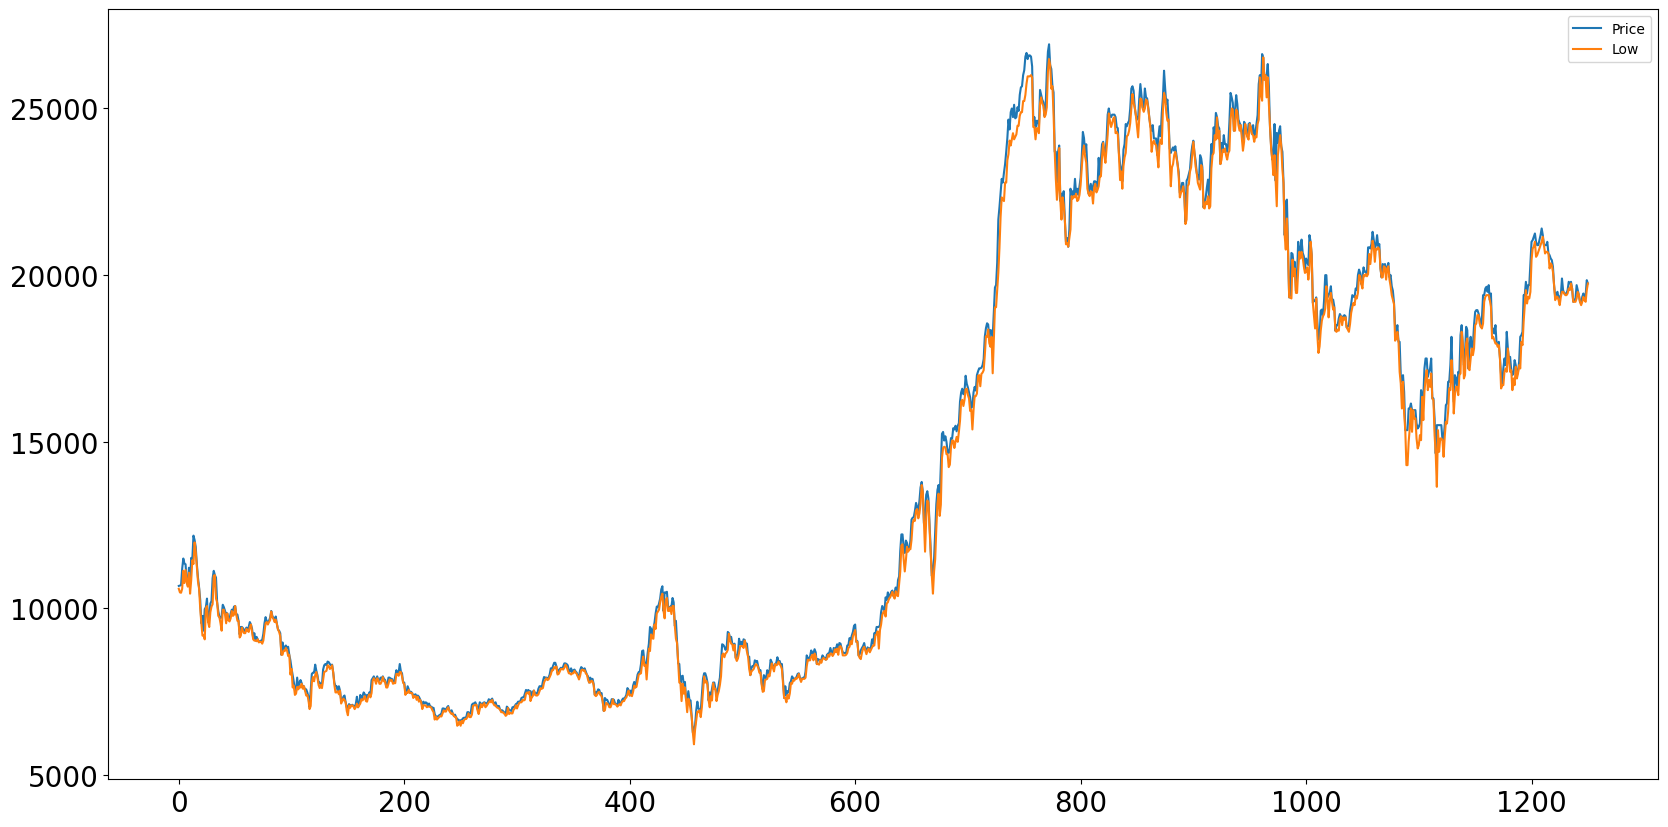

In [ ]:
df.plot(figsize=(20, 10), fontsize=20)
plt.show()

***Tìm m thích hợp***

In [ ]:
# Dùng adf để kiểm tra xem dataset có stationary hay chưa
from statsmodels.tsa.stattools import adfuller
adfuller(df['Price'])

(-1.0092114971561106,
 0.7498898098466933,
 23,
 1227,
 {'1%': -3.435690695421723,
  '5%': -2.863898416697677,
  '10%': -2.5680256555204184},
 17822.00618770349)

In [ ]:
# Vì dataset chưa stationary nên ta thực hiện diff()
df_diff = df1['Price'].diff().dropna()

In [ ]:
# Tiếp tục dùng adf để kiểm tra xem p value có < 0.05 ko
adfuller(df_diff)

(-6.764614757025684,
 2.7371502262804035e-09,
 22,
 1227,
 {'1%': -3.435690695421723,
  '5%': -2.863898416697677,
  '10%': -2.5680256555204184},
 17807.55746247881)

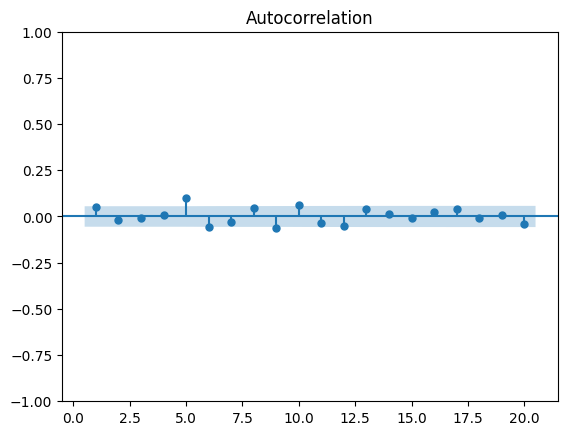

In [ ]:
# Sau khi dataset đã stationary vẽ acf để tìm m
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_diff, lags = 20 , zero = False)
plt.show()

**3. Dùng auto_arima để tìm model thích hợp**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df

,Price,Low
0,10676.9,10590.4
1,10687.7,10482.4
2,10698.5,10471.6
3,11195.6,10590.4
4,11498.2,11130.8
...,...,...
1246,19450.0,19350.0
1247,19300.0,19250.0
1248,19400.0,19200.0
1249,19850.0,19550.0


In [ ]:
# Tạo y_train, x_train
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Dùng auto_arima để tìm thông số thích hợp
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m =5)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[5]             : AIC=inf, Time=4.55 sec
 ARIMA(0,2,0)(0,0,0)[5]             : AIC=12852.360, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[5]             : AIC=12630.203, Time=0.23 sec
 ARIMA(0,2,1)(0,0,1)[5]             : AIC=inf, Time=1.34 sec
 ARIMA(1,2,0)(0,0,0)[5]             : AIC=12631.336, Time=0.09 sec
 ARIMA(1,2,0)(2,0,0)[5]             : AIC=12624.596, Time=0.30 sec
 ARIMA(1,2,0)(2,0,1)[5]             : AIC=12626.578, Time=0.73 sec
 ARIMA(1,2,0)(1,0,1)[5]             : AIC=12628.355, Time=0.46 sec
 ARIMA(0,2,0)(2,0,0)[5]             : AIC=12838.679, Time=0.26 sec
 ARIMA(2,2,0)(2,0,0)[5]             : AIC=12567.788, Time=0.39 sec
 ARIMA(2,2,0)(1,0,0)[5]             : AIC=12570.562, Time=0.28 sec
 ARIMA(2,2,0)(2,0,1)[5]             : AIC=12569.429, Time=0.93 sec
 ARIMA(2,2,0)(1,0,1)[5]             : AIC=12569.759, Time=0.69 sec
 ARIMA(3,2,0)(2,0,0)[5]             : AIC=12541.347, Time=0.54 sec
 ARIMA(3,2,0)(1,0,0)[5]        

**Dùng SARIMAX để train model**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model1 = SARIMAX(y_train, exog = np.array(train_data['Price']), order=(4,2,0), seasonal_order=(2, 0, 0, 5))
model_fit = model1.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**4. Quá trình test**

In [ ]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
exg = np.array(test_data['Low'])
y_pred_test = model_fit.predict(start=len(y_train), end=len(y_test)+len(y_train)-1, exog=exg)
y_pred_test

array([25333.3, 24866.7, 24633.3, 24666.7, 23533.3, 22666.7, 23233.3,
       23333.3, 23600. , 23700. , 23533.3, 23333.3, 22966.7, 22333.3,
       22466.7, 22533.3, 22666.7, 22400. , 21533.3, 21666.7, 22666.7,
       22733.3, 23100. , 23233.3, 23633.3, 24000. , 23666.7, 23266.7,
       23066.7, 22766.7, 22666.7, 22566.7, 23300. , 23133.3, 22033.3,
       22000. , 22200. , 22133.3, 22366.7, 22000. , 22066.7, 23200. ,
       23600. , 23666.7, 24200. , 24066.7, 24733.3, 24100. , 24333.3,
       23333.3, 23466.7, 23766.7, 23700. , 23800. , 23600. , 23466.7,
       23666.7, 23733.3, 24666.7, 25000. , 24966.7, 24333.3, 24333.3,
       24966.7, 24900. , 24500. , 24333.3, 24500. , 24133.3, 23733.3,
       24000. , 24533.3, 24300. , 24133.3, 24066.7, 24533.3, 24433.3,
       24233.3, 24200. , 24000. , 24166.7, 24133.3, 24533.3, 24666.7,
       25933.3, 25433.3, 25233.3, 26533.3, 25866.7, 26000. , 25333.3,
       25933.3, 25133.3, 24433.3, 23800. , 23466.7, 23000. , 23600. ,
       22833.3, 2206

**5. Quá trình validate**

In [ ]:
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
last_index = df.index[-1]
exg = np.array(val_data['Low'])
y_pred_val = model_fit.predict(start=len(x_train), end = len(x_train)+ len(y_val)-1, exog=exg)
y_pred_val

array([15550., 15900., 16600., 16550., 17450., 16900., 15850., 16400.,
       16650., 16650., 16400., 17000., 17050., 18300., 17950., 16900.,
       17000., 17950., 18100., 17200., 17150., 17500., 17800., 17600.,
       17800., 18500., 18550., 18800., 18800., 18550., 18450., 18400.,
       18550., 19200., 19350., 19400., 19400., 19400., 19250., 19050.,
       18100., 18150., 18050., 17950., 17950., 17850., 17900., 17500.,
       16600., 16700., 16700., 17100., 17200., 17100., 17800., 17450.,
       17100., 17150., 16550., 16900., 16700., 17250., 16900., 17050.,
       17300., 17200., 18000., 17900., 18600., 19100., 19550., 19150.,
       19350., 19300., 19500., 20450., 20800., 20850., 21000., 20550.,
       20600., 20700., 20800., 20900., 21000., 21150., 20900., 20650.,
       20700., 20700., 20650., 20200., 20350., 20300., 20100., 19700.,
       19250., 19350., 19350., 19250., 19100., 19350., 19500., 19500.,
       19450., 19400., 19400., 19450., 19600., 19550., 19750., 19600.,
      

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [ ]:
# Dùng thuật toán LR để tìm giá trị Low cho 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Low'])

last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Dự đoán giá trị low 30 ngày tiếp theo
low_next_30_days = ln_model.predict(x_next_30_days)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.predict(start=len(x_train), end = len(x_train)+ len(x_next_30_days)-1, exog=low_next_30_days)
# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[25697.32113553 25714.81087451 25732.3006135  25749.79035249
 25767.28009148 25784.76983046 25802.25956945 25819.74930844
 25837.23904742 25854.72878641 25872.2185254  25889.70826439
 25907.19800337 25924.68774236 25942.17748135 25959.66722033
 25977.15695932 25994.64669831 26012.1364373  26029.62617628
 26047.11591527 26064.60565426 26082.09539324 26099.58513223
 26117.07487122 26134.56461021 26152.05434919 26169.54408818
 26187.03382717 26204.52356615]


***7.Đánh giá độ chính xác thuật toán***

In [ ]:
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred_test - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 372.8376811803449
Testing RMSE: 470.94104480285
Validation MAPE: 1.427321954331313
Testing MAPE: 1.578838269990909
Validation MAE: 265.87301587301585
Testing MAE: 319.0672


**8. Vẽ biểu đồ**

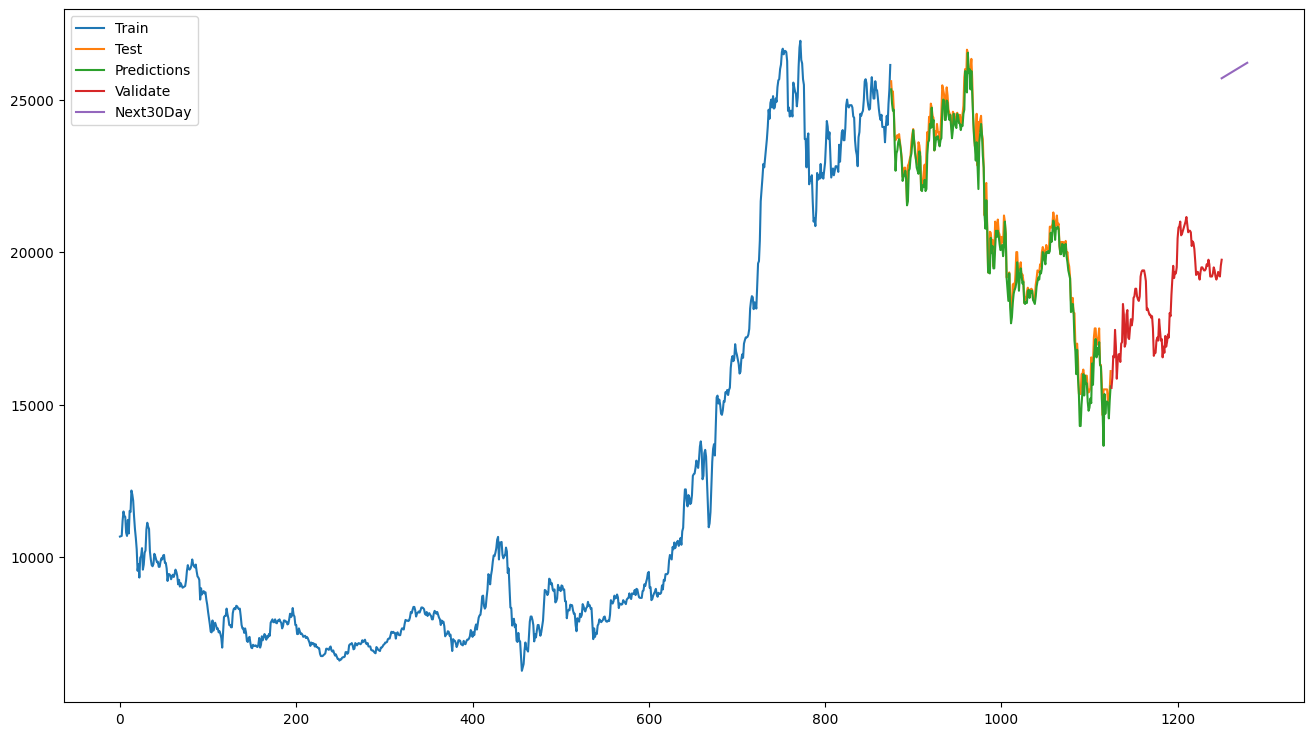

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()